This is a demonstration of how one defines a Nerual Network using torch's Modules. This notebook defines the simplest neural network with only Input layers, Fully Connected Layers and Output Layers.\
For ease of reference, this architecture of the neural network is referred to as a 'Fully Connected Network' throughout the whole topic.

In [96]:
import torch

from torch import nn
from torch.utils.data import random_split, DataLoader, Dataset

import matplotlib.pyplot as plt

import math

# Sample Data

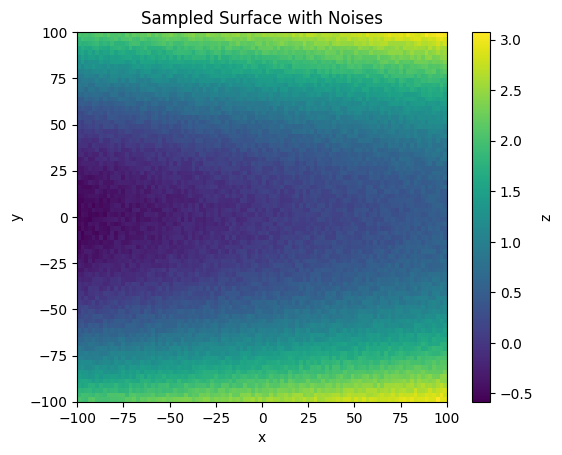

In [97]:
x = torch.linspace(-100, 100, 100)
y = torch.linspace(-100, 100, 80)

xx, yy = torch.meshgrid(x, y, indexing='xy')

z = (5 * xx + (0.5 * yy) ** 2 - 100) / 1000 + torch.rand(xx.shape) * .2


plt.imshow(z, extent=[x[0], x[-1], y[0], y[-1]])
plt.title('Sampled Surface with Noises')
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('z')

In [98]:
features = torch.cat([xx.reshape((-1,1)), yy.reshape((-1,1))], 1)
labels = z.reshape((-1, 1))

# First Model Definition

In [99]:
class ParabolaDataset(Dataset):
    def __init__(self, features, targets):
        if features.shape[0] != targets.shape[0]:
            raise ValueError('Features and Labels have different lengths!')
        super().__init__()
        self.features = features
        self.targets = targets
    
    def __len__(self) -> int:
        return self.features.shape[0]
    
    def __getitem__(self, index):
        return self.features[index], self.targets[index]

In [100]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    loss_fn: nn.Module,
    optimizer: nn.Module,
    track_loss: bool = False
):
    """
    Performs backpropogation on `model` using `optimizer`.

    :param nn.Module model: The model on which to perform backpropogation.
    :param nn.utils.data.DataLoader train_loader: A DataLoader dispatching batches
        for each backpropogations.
    :param nn.Module loss_fn: The loss function to based on which to compute gradients.
    :param nn.Module optimizer: The optimization algorithm for gradient descent.
    :param bool track_loss: Whether or not to print out statistics on each backpropogation.
        This is `False` by default.
    """
    model.train()
    if track_loss:
        num_digits = int(math.log10(len(train_loader))) + 1
    for batch, (X, y) in enumerate(train_loader, start=1):
        pred_value = model(X)
        loss = loss_fn(pred_value, y)

        # Compute the gradient with loss.backward()
        # Then backpropogate with optimizer.step()
        # However, to avoid accumulation of previous backward passes
        # we need to call optimizer.zero_grad() to zero out the gradient
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if track_loss:
            print(f"Batch {batch:>{num_digits}}/{len(train_loader)} || Loss: {loss}")
def test_model(
    model: nn.Module,
    test_loader: DataLoader,
    loss_fn: nn.Module,
    compute_accuracy: bool
) -> tuple[float, float]:
    """
    Evaluate `model` based on `loss_fn` and return the average score(s).

    :param nn.Module model: The model on which to perform evaluation.
    :param nn.utils.data.DataLoader test_loader: A DataLoader containing test data.
    :param nn.Module loss_fn: The loss function to based on which to compute metrics.
    :param bool compute_accuracy: Whether or not to compute accuracy. This is only
        meaningful in the case the `model` is a classifier.
    :return: The average loss (per batch) and average accuracy (per sample). If
        `compute_accuracy=False` then average accuracy returned is 0.
    :rtype: tuple[float, float]
    """
    model.eval()
    total_loss, total_accuracy = 0, 0
    for X, y in test_loader:
        pred = model(X)
        total_loss += loss_fn(pred, y)
        if compute_accuracy:
            labels = (pred.argmax(dim=1) == y)
            total_accuracy += labels.type(torch.int).sum().item()
    return total_loss / len(test_loader), total_accuracy / len(test_loader.dataset)


class SimpleNetwork(nn.Module):
    """
    A simple Feed Forward Network with only Fully Connected Layers.
    The activation function used for the layer is ReLU()
    """
    def __init__(self, input_dim, output_dim, hidden_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, values):
        return self.layers(values)

# Training and Evaluation

In [ ]:
def train_epochs(
    model: nn.Module,
    train_loader: tuple[DataLoader, DataLoader],
    test_loader: tuple[DataLoader, DataLoader],
    loss_fn: nn.Module,
    optimizer: nn.Module,
    epochs: int
):
    num_dig = int(math.log10(epochs)) + 1
    update_rate = 1 if epochs <= 20 else 10

    for epoch in range(epochs):
        if not epoch % update_rate:
            print(f"Epoch {epoch + 1:>{num_dig}}/{epochs}", end=' || ')
        train_model(model, train_loader, loss_fn, optimizer)
        loss, acc = test_model(model, test_loader, loss_fn, False)
        if not epoch % update_rate:
            print(f"Average Loss: {loss:.6f}")

In [105]:
batch_size = 64
learning_rate = 0.0001

train, test = random_split(ParabolaDataset(features, labels), [.8, .2])
train_loader = DataLoader(train, batch_size, True)
test_loader = DataLoader(test, batch_size, True)

model = SimpleNetwork(2, 1, 10)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [106]:
train_epochs(model, train_loader, test_loader, loss_fn, optimizer,
             20)

Epoch  1/20 || Average Loss: 1.089699
Epoch  2/20 || Average Loss: 0.590572
Epoch  3/20 || Average Loss: 0.358210
Epoch  4/20 || Average Loss: 0.250154
Epoch  5/20 || Average Loss: 0.192270
Epoch  6/20 || Average Loss: 0.158285
Epoch  7/20 || Average Loss: 0.130146
Epoch  8/20 || Average Loss: 0.112695
Epoch  9/20 || Average Loss: 0.100455
Epoch 10/20 || Average Loss: 0.093055
Epoch 11/20 || Average Loss: 0.087761
Epoch 12/20 || Average Loss: 0.085721
Epoch 13/20 || Average Loss: 0.083144
Epoch 14/20 || Average Loss: 0.081676
Epoch 15/20 || Average Loss: 0.079580
Epoch 16/20 || Average Loss: 0.079850
Epoch 17/20 || Average Loss: 0.078667
Epoch 18/20 || Average Loss: 0.077744
Epoch 19/20 || Average Loss: 0.078253
Epoch 20/20 || Average Loss: 0.076993


# Weights Interpretation
The purpose of this section is to demonstrate how the activation function introduce non-linearity into the model.
This also show how good the model can fit into seen data.\
However, this ONLY shows a part of the model's performance. One must also judge how good the model fits into unseen
data in order to accurately determine the model's performance.

In [107]:
state_dict = model.state_dict()
state_dict

OrderedDict([('layers.1.weight',
              tensor([[-0.2664, -0.5664],
                      [-0.4033,  0.0651],
                      [-0.1572, -0.2665],
                      [ 0.1259,  0.2500],
                      [ 0.0935, -0.3832],
                      [-0.0803,  0.6734],
                      [ 0.0507, -0.2721],
                      [-0.3081,  0.5681],
                      [ 0.4007, -0.0652],
                      [-0.1020,  0.5529]])),
             ('layers.1.bias',
              tensor([ 0.2409, -0.0203,  0.4632,  0.3718, -0.6432,  0.3500,  0.5898,  0.1329,
                      -0.5255, -0.1721])),
             ('layers.3.weight',
              tensor([[ 0.1968, -0.1802, -0.0594, -0.3179, -0.1213, -0.0748, -0.1482, -0.0040,
                        0.1613,  0.2993]])),
             ('layers.3.bias', tensor([0.2068]))])

In [109]:
linear_comb = features @ state_dict['layers.1.weight'].T
first_layer_res = torch.relu(linear_comb + state_dict['layers.1.bias'])
linear_comb_2 = first_layer_res @ state_dict['layers.3.weight'].T
output_layer = linear_comb_2 + state_dict['layers.3.bias']
output_layer

# or easily call model(features)
# remember to set model to eval before interference

tensor([[1.2002],
        [1.2219],
        [1.2435],
        ...,
        [2.3315],
        [2.3341],
        [2.3367]])

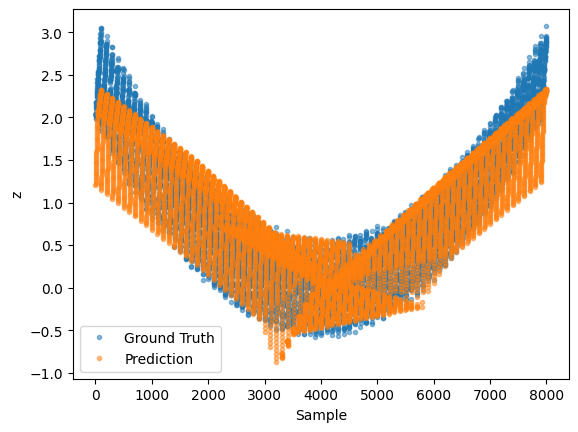

In [110]:
plt.plot(labels, '.', label='Ground Truth', alpha=.5)
plt.plot(output_layer, '.', label='Prediction', alpha=.5)
plt.xlabel('Sample')
plt.ylabel('z')
plt.legend();

In [156]:
def draw_predicted_surface(
    heights, ax,
    title='',
    extent=None
):
    img = ax.imshow(heights, extent=extent)
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    cbar = ax.get_figure().colorbar(img)
    cbar.set_label('z');
    return ax, img

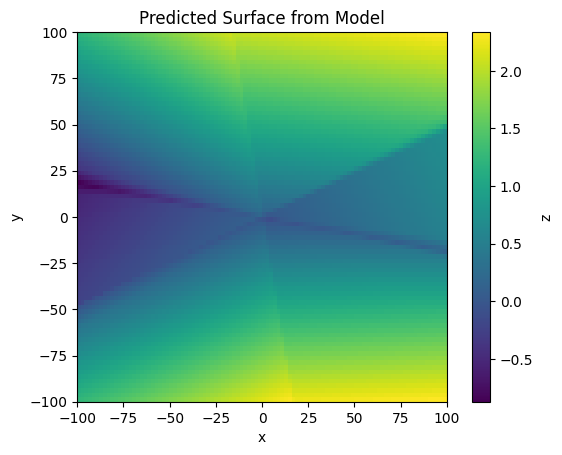

In [ ]:
draw_predicted_surface(
    output_layer.reshape(xx.shape), plt.gca(),
    'Predicted Surface from Model',
    [x[0], x[-1], y[0], y[-1]]
)

# Second Model Definition

In [ ]:
class MultiLayerPerceptron(nn.Module):
    """
    A Feed Forward Network with only Fully Connected Layers.
    The activation function used for the layer is ReLU()
    """
    def __init__(self,
        input_output_dim: tuple[int, int],
        hidden_dim: tuple[int]
    ):
        super().__init__()
        self.layers = nn.Sequential(nn.Flatten())

        relu = nn.ReLU()
        hidden_dim = input_output_dim[0:1] + hidden_dim
        for i in range(1, len(hidden_dim)):
            self.layers.add_module(f'{2 * i - 1}', nn.Linear(hidden_dim[i-1], hidden_dim[i]))
            self.layers.add_module(f'{2 * i}', relu)
        self.layers.add_module(f'out', nn.Linear(hidden_dim[-1], input_output_dim[1]))
        
    def forward(self, values):
        return self.layers(values)

Training and Evaluation

In [172]:
learning_rate = 0.001

train, test = random_split(ParabolaDataset(features, labels), [.8, .2])
train_loader = DataLoader(train, batch_size, True)
test_loader = DataLoader(test, batch_size, True)

mlp_model_1 = MultiLayerPerceptron((2, 1), (10, 10))
mlp_model_2 = MultiLayerPerceptron((2, 1), (50, 50))
mlp_model_3 = MultiLayerPerceptron((2, 1), (50, 50, 50, 50))

loss_fns = [nn.MSELoss(), nn.MSELoss(), nn.MSELoss()]
optimizers = [
    torch.optim.SGD(mlp_model_1.parameters(), lr=learning_rate),
    torch.optim.SGD(mlp_model_2.parameters(), lr=learning_rate),
    torch.optim.SGD(mlp_model_3.parameters(), lr=learning_rate),
]

In [173]:
epochs = 40

print('Training First Model:')
train_epochs(mlp_model_1, train_loader, test_loader, loss_fns[0], optimizers[0],
             epochs)

print('\nTraining Second Model:')
train_epochs(mlp_model_2, train_loader, test_loader, loss_fns[1], optimizers[1],
             epochs)

print('\nTraining Third Model:')
train_epochs(mlp_model_3, train_loader, test_loader, loss_fns[2], optimizers[2],
             epochs)

Training First Model:
Epoch  1/40 || Average Loss: 0.080099
Epoch 11/40 || Average Loss: 0.049592
Epoch 21/40 || Average Loss: 0.040729
Epoch 31/40 || Average Loss: 0.034606

Training Second Model:
Epoch  1/40 || Average Loss: 0.100300
Epoch 11/40 || Average Loss: 0.042316
Epoch 21/40 || Average Loss: 0.037073
Epoch 31/40 || Average Loss: 0.032689

Training Third Model:
Epoch  1/40 || Average Loss: 0.073706
Epoch 11/40 || Average Loss: 0.042291
Epoch 21/40 || Average Loss: 0.033966
Epoch 31/40 || Average Loss: 0.029418


Interpreting the weights

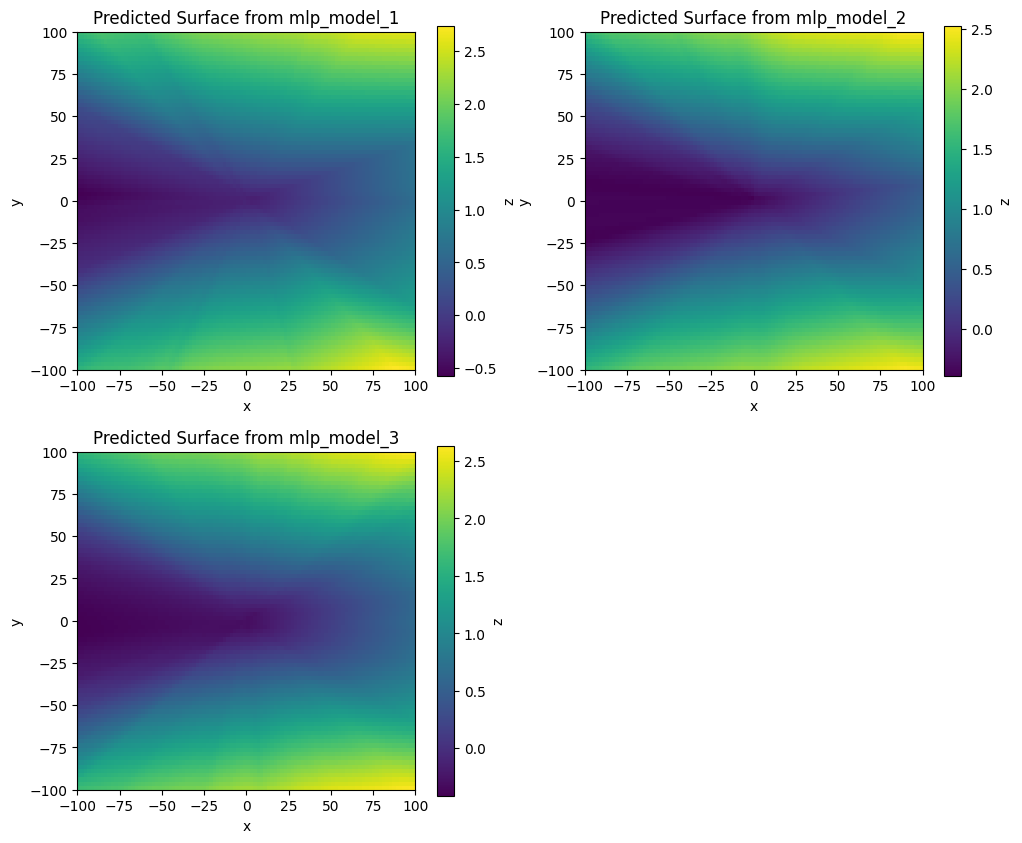

In [174]:
mlp_model_1.eval()
mlp_model_2.eval()
mlp_model_3.eval()
predictions = [
    mlp_model_1(features).detach(),
    mlp_model_2(features).detach(),
    mlp_model_3(features).detach(),
]


fig = plt.figure(figsize=(12, 10))
fig.tight_layout()
axes = fig.subplot_mosaic(
    [[0, 1], [2, '.']]
)

extent = [x[0], x[-1], y[0], y[-1]]
temp_title_fn = lambda num: f'Predicted Surface from mlp_model_{num}'
draw_predicted_surface(
    predictions[0].reshape(xx.shape), axes[0],
    temp_title_fn(1),
    extent=extent
)
draw_predicted_surface(
    predictions[1].reshape(xx.shape), axes[1],
    temp_title_fn(2),
    extent=extent
)
draw_predicted_surface(
    predictions[2].reshape(xx.shape), axes[2],
    temp_title_fn(3),
    extent=extent
);